# Data and Figures for Decomposition Study

In [52]:
import pandas as pd 
from glob import glob
from collections import defaultdict
from copy import deepcopy

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from eventgraphs import EventGraph

In [107]:
complete_cuts = {}
complete_cuts_interval = {}

for file in glob('./data/eventgraphs/*'):
    filename = file.split('/')[-1].split('.')[0]
    print(filename)
    EG = EventGraph.from_file(file)
    
    # Joining tables for ease.
    combined = pd.merge(EG.eg_edges, 
                    EG.events, 
                    left_on='source', 
                    right_index=True,
                    suffixes=('', '_void'))[['delta','source','target','time']]
    combined = combined.rename(columns={'time':'source_time'})
    combined = pd.merge(combined, 
                        EG.events, 
                        left_on='target', 
                        right_index=True,
                        suffixes=('', '_void'))[['delta','source','target','source_time', 'time']]
    combined = combined.rename(columns={'time':'target_time'})
    
    # Finding cuts
    cuts = {}
    cuts_interval = {}
    for x in np.logspace(np.log10(2),3,10).astype(int):
        interval_split = np.linspace(0, EG.D, x)
        delta_store = []

        for ix, row in combined.iterrows():
            if np.searchsorted(interval_split, row.source_time) != np.searchsorted(interval_split, row.target_time):
                delta_store.append(row.delta)

        delta_store = pd.Series(delta_store)

        distribution = (delta_store.value_counts().sort_index().cumsum()/len(EG.eg_edges))
        try:
            ix = distribution.index.get_loc(EG.D/x, method='bfill')
        except:
            ix = -1
        cuts[x] = distribution.iloc[-1]
        cuts_interval[x] = distribution.iloc[ix]
    
    complete_cuts[filename] = pd.Series(cuts)
    complete_cuts_interval[filename] = pd.Series(cuts_interval)    

twitter-emirates
random-er
academic-coauthors
sociopatterns-primary
social-ucirvine


In [118]:
import pickle

complete = {'complete_cuts_interval':complete_cuts_interval,
            'complete_cuts':complete_cuts}

with open('./data/decomposition.pkl', 'wb') as file:
    pickle.dump(complete, file)

In [60]:
import pickle
with open('./data/decomposition.pkl', 'rb') as file:
    complete = pickle.load(file)

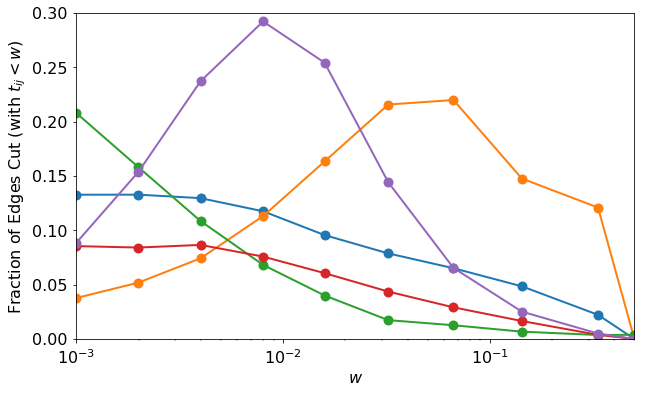

In [67]:
from plotting import PLOT_STYLE

with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    for key, val in complete['complete_cuts_interval'].items():

        val = deepcopy(val)
        val.index = 1/val.index
        val = val.sort_index()
        #print(val)
        val.plot(label=key, ax=ax, marker='o', markersize=10)
    #ax.legend(loc='best', fontsize=11,);
    ax.set_xscale('log')
    
    ax.set_xlabel("$w$")
    ax.set_ylabel("Fraction of Edges Cut (with $t_{ij}<w$)")
    
    ax.set_ylim((0,0.3))
    ax.set_xlim((1e-3,0.5))
    
    fig.savefig('./figures/percolation_timescale_cut.eps', bbox_inches='tight')

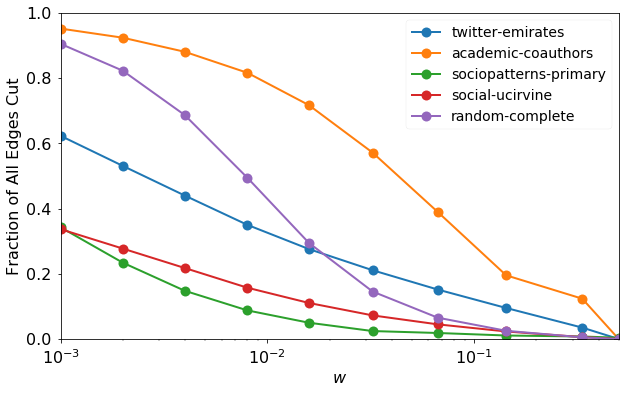

In [68]:
with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    for key, val in complete['complete_cuts'].items():

        val = deepcopy(val)
        val.index = 1/val.index
        val = val.sort_index()
        #print(val)
        val.plot(label=key, ax=ax, marker='o', markersize=10)
    ax.legend(loc='best', fontsize=14,);
    ax.set_xscale('log')
    
    ax.set_xlabel("$w$")
    ax.set_ylabel("Fraction of All Edges Cut")
    
    ax.set_ylim((0,1))
    ax.set_xlim((1e-3,0.5))
    
    
    fig.savefig('./figures/percolation_cut.eps', bbox_inches='tight')    